#Grad-CAM
In this section we will use ResNet along with the Gradient-weighted Class Activation Mapping (Grad-CAM) technique to analyze how our models are looking at the images to find the boundaries encircling the prohibited items.

In [1]:
import os
import cv2
import json
import numpy as np
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
#We'll mount the drive to access the data.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### First we'll load the data:

In [3]:
# Define the base directories and image metrics
BASE = "/content/drive/MyDrive/Colab Data"
RAW_POS = f"{BASE}/DvXray_Positive_Samples"

IMG_W = 800
IMG_H = 600
TRAIN_RATIO = 0.8

In [4]:
pos_ids = []
for f in os.listdir(RAW_POS):
    if f.endswith(".json"):
        pos_ids.append(f.replace(".json", ""))

We can now load the images and their boundary.

In [5]:
def get_image_array(path):
  image = Image.open(path)
  return np.array(image) / 255.0

def get_formatted_metadata(point):
    return  [point[0]/IMG_W, point[1]/IMG_H, point[2]/IMG_W, point[3]/IMG_H]

def de_format_metadata(point):
    return [point[0]*IMG_W, point[1]*IMG_H, point[2]*IMG_W, point[3]*IMG_H]

In [6]:
X = []
y = []

for i in tqdm(range(750), desc="Processing"): #len(pos_ids)
  metadata = json.load(open(f"{RAW_POS}/{pos_ids[i]}.json"))

  ol_array = metadata['objects'][0]['ol_bb']
  if ol_array != 'difficult':
    X.append(get_image_array(f"{RAW_POS}/{pos_ids[i]}_OL.png"))
    y.append(get_formatted_metadata(ol_array))

  sd_array = metadata['objects'][0]['sd_bb']
  if sd_array != 'difficult':
    X.append(get_image_array(f"{RAW_POS}/{pos_ids[i]}_SD.png"))
    y.append(get_formatted_metadata(sd_array))

Processing: 100%|██████████| 750/750 [02:06<00:00,  5.95it/s]


In [7]:
y = np.array(y)
X = np.array(X)

### We can now define and train the ResNet model we will use to visualize the network:

In [8]:
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, MaxPooling2D, Input, Flatten
from keras.regularizers import l2

#Next we create the Neural Network model:
class CustomResNetModel(tf.keras.Model):
  def __init__(self):
      super().__init__()
      self.resnet_1_conv=Conv2D(64, kernel_size=[7,7],strides=2,padding='same',kernel_initializer='he_normal' ,kernel_regularizer=l2(1e-3))
      self.resnet_1_norm=BatchNormalization()
      self.resnet_1_act=Activation('relu')

      self.pool_1 = MaxPooling2D([3,3],2,'same')

      #Block 1
      self.resnet_2_conv=Conv2D(64, kernel_size=[3,3],strides=1,padding='same',kernel_initializer='he_normal' ,kernel_regularizer=l2(1e-3))
      self.resnet_2_norm=BatchNormalization()
      self.resnet_2_act=Activation('relu')

      self.resnet_3_conv=Conv2D(64, kernel_size=[3,3],strides=1,padding='same',kernel_initializer='he_normal' ,kernel_regularizer=l2(1e-3))
      self.resnet_3_norm=BatchNormalization()
      self.resnet_3_act=Activation('relu')

      #Block 2
      self.resnet_4_conv=Conv2D(64, kernel_size=[3,3],strides=1,padding='same',kernel_initializer='he_normal' ,kernel_regularizer=l2(1e-3))
      self.resnet_4_norm=BatchNormalization()
      self.resnet_4_act=Activation('relu')

      self.resnet_5_conv=Conv2D(64, kernel_size=[3,3],strides=1,padding='same',kernel_initializer='he_normal' ,kernel_regularizer=l2(1e-3))
      self.resnet_5_norm=BatchNormalization()
      self.resnet_5_act=Activation('relu')

      #Block 3
      self.resnet_6_conv=Conv2D(128, kernel_size=[1,1],strides=2,padding='same',kernel_initializer='he_normal' ,kernel_regularizer=l2(1e-3))
      self.resnet_6_norm=BatchNormalization()
      self.resnet_6_act=Activation('relu')

      self.resnet_7_conv=Conv2D(128, kernel_size=[3,3],strides=1,padding='same',kernel_initializer='he_normal' ,kernel_regularizer=l2(1e-3))
      self.resnet_7_norm=BatchNormalization()
      self.resnet_7_act=Activation('relu')

      self.resnet_7_conv_ext=Conv2D(128, kernel_size=[1,1],strides=2,padding='same',kernel_initializer='he_normal' ,kernel_regularizer=l2(1e-3))

      #Block 3.5
      self.resnet_8_conv=Conv2D(128, kernel_size=[3,3],strides=1,padding='same',kernel_initializer='he_normal' ,kernel_regularizer=l2(1e-3))
      self.resnet_8_norm=BatchNormalization()
      self.resnet_8_act=Activation('relu')

      self.resnet_9_conv=Conv2D(128, kernel_size=[3,3],strides=1,padding='same',kernel_initializer='he_normal' ,kernel_regularizer=l2(1e-3))
      self.resnet_9_norm=BatchNormalization()
      self.resnet_9_act=Activation('relu')



      #Out Block
      self.flatten=Flatten()

      self.dense_1=Dense(1000,kernel_initializer='he_normal',activation='relu',kernel_regularizer=l2(1e-3))
      self.dense_2=Dense(4,kernel_initializer='he_normal',activation='sigmoid', kernel_regularizer=l2(1e-3))


  def call(self, inputs, train=False, grad=False):
      x = self.resnet_1_conv(inputs, training=train)
      x = self.resnet_1_norm(x, training=train)
      x = self.resnet_1_act(x, training=train)

      x = self.pool_1(x, training=train)

      #Block 1
      a = self.resnet_2_conv(x, training=train)
      a = self.resnet_2_norm(a, training=train)
      a = self.resnet_2_act(a, training=train)

      a = self.resnet_3_conv(a, training=train)
      a = self.resnet_3_norm(a, training=train)

      x = tf.keras.layers.add([x,a])
      x = self.resnet_3_act(x, training=train)

      #Block 2
      a = self.resnet_4_conv(x, training=train)
      a = self.resnet_4_norm(a, training=train)
      a = self.resnet_4_act(a, training=train)

      a = self.resnet_5_conv(a, training=train)
      a = self.resnet_5_norm(a, training=train)

      x = tf.keras.layers.add([x,a])
      x = self.resnet_5_act(x, training=train)

      #Block 3
      a = self.resnet_6_conv(x, training=train)
      a = self.resnet_6_norm(a, training=train)
      a = self.resnet_6_act(a, training=train)

      a = self.resnet_7_conv(a, training=train)
      a = self.resnet_7_norm(a, training=train)

      x = self.resnet_7_conv_ext(x, training=train)

      x = tf.keras.layers.add([x,a])
      x = self.resnet_7_act(x, training=train)

      #BLock 3.5
      a = self.resnet_8_conv(x, training=train)
      a = self.resnet_8_norm(a, training=train)
      a = self.resnet_8_act(a, training=train)

      a = self.resnet_9_conv(a, training=train)
      a = self.resnet_9_norm(a, training=train)

      x = tf.keras.layers.add([x,a])
      x = self.resnet_9_act(x, training=train)


      x_grad = x

      #Out Block
      x = self.flatten(x, training=train)
      x = self.dense_1(x, training=train)
      x = self.dense_2(x, training=train)

      return x if not grad else (x_grad, x)

  def train_step(self, data):
      x, y = data

      with tf.GradientTape() as tape:
          y_pred = self.call(x, train=True)
          loss = self.compute_loss(y=y, y_pred=y_pred)

      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      #Calculating metrics
      for metric in self.metrics:
          if metric.name == "loss":
              metric.update_state(loss)
          else:
              metric.update_state(y, y_pred)
      return {m.name: m.result() for m in self.metrics}

In [9]:
class StopOnLoss(tf.keras.callbacks.Callback):
  def __init__(self, x):
    super(StopOnLoss, self).__init__()
    self.x = x
  def on_epoch_end(self, epoch, logs=None):
      print(self.model.call(self.x))

In [38]:
n_epochs=300
lr = 0.0000005

optim = tf.keras.optimizers.Adam(learning_rate=lr, global_clipnorm=1.0)
loss_fn = tf.keras.losses.MeanAbsoluteError()

model = CustomResNetModel()
model.compile(optimizer=optim, loss=loss_fn)

history = model.fit(X, y, epochs=n_epochs, callbacks=[StopOnLoss(X[0:1])])

Epoch 1/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 4.2201tf.Tensor([[0.14995348 0.006179   0.97741    0.484329  ]], shape=(1, 4), dtype=float32)
45/45 ━━━━━━━━━━━━━━━━━━━━ 86s 254ms/step - loss: 4.2195
Epoch 2/300
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 4.1326tf.Tensor([[0.4387089  0.38675112 0.581978   0.6939717 ]], shape=(1, 4), dtype=float32)
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - loss: 4.1323
Epoch 3/300
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 4.0907tf.Tensor([[0.30112132 0.4052084  0.4409435  0.5994279 ]], shape=(1, 4), dtype=float32)
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 4.0908
Epoch 4/300
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 4.0648tf.Tensor([[0.41185597 0.563326   0.51401144 0.6146772 ]], shape=(1, 4), dtype=float32)
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 4.0647
Epoch 5/300
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 4.0453tf.Tensor([[0.4150848  0.64478624 0.40285748 0.5071529 ]], shape=(1, 4), dtype=float32)


### We can now use Grad-Cam to create a heatmap that will visualize how the model finds parts to pay attention to in the images:

In [39]:
def visualize_gradcam(index=0):
  with tf.GradientTape() as tape:
    conv_outputs, predictions = model.call(X[index:index+1], grad=True)
    loss = predictions

  grads = tape.gradient(loss, conv_outputs)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
  print(conv_outputs.shape)
  conv_outputs = conv_outputs.numpy()[0]
  pooled_grads = pooled_grads.numpy()

  for i in range(pooled_grads.shape[-1]):
    conv_outputs[:, :, i] *= pooled_grads[i]

  heatmap = np.mean(conv_outputs, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.resize(heatmap, dsize=(IMG_W, IMG_H), interpolation=cv2.INTER_CUBIC)

  print(heatmap.shape)

  fig, ax = plt.subplots()
  ax.imshow(X[index])
  ax.imshow(heatmap, alpha=0.5, cmap='jet')
  ax.axis('off')

(1, 75, 100, 128)
(600, 800)


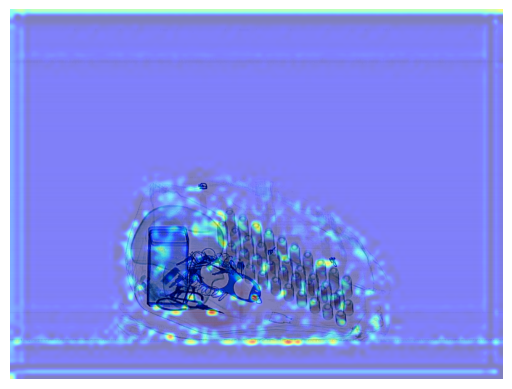

In [43]:
visualize_gradcam(1)

(1, 75, 100, 128)
(600, 800)


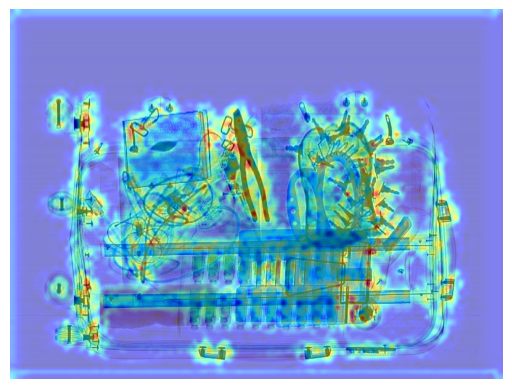

In [42]:
visualize_gradcam(2)

(1, 75, 100, 128)
(600, 800)


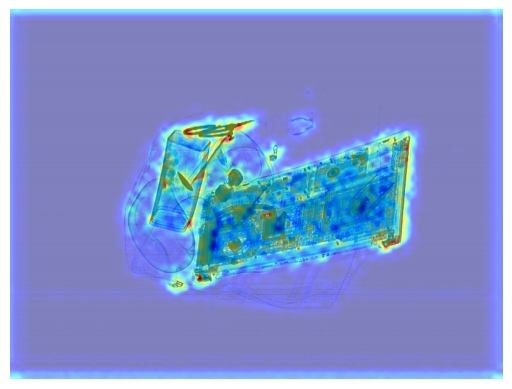

In [44]:
visualize_gradcam(4)

### Results:
As can be seen in the images, the model ignores empty spaces while paying attention to shapes and edges along with surfaces that are distinct from the background. We can also observe that there is special attention paid to the edges of prohibited items which help the model identify the items.